# HAL (HAWC Accelerated Likelihood) plugin

In [1]:
import warnings

warnings.simplefilter("ignore")
import numpy as np

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

The High-Altitude Water Cherenkov Observatory ([HAWC](https://www.hawc-observatory.org/)) is a ground-based wide-field TeV gamma-ray observatory located in Mexico, scanning about 2/3 of the northern sky every day. It is sensitive to gamma rays in the energy range from hundreds of GeV to hundreds of TeV. In addition to gamma ray-induced air showers, HAWC also detects signals from cosmic-ray induced air showers, which make up the main (and partially irreducible) background. HAWC uses a forward-folding likelihood analysis, similar to the approach that is used e.g. by many Fermi-LAT analyses. Most of HAWC's data are only available to collaboration members. However, HAWC has released several [partial-sky datasets](https://data.hawc-observatory.org/) to the public, and is committed to releasing more in the future. If you are interested in a particular HAWC dataset, you can find contact information for HAWC working group leaders on the linked webpage.

The HAL (HAWC Accelerated Likelihood) plugin for threeML is provided in a separate python package, `hawc_hal`. Before running this example offline, make sure that the `HAL` package is installed. The `hawc_hal` package has a few dependencies: `uproot, awkward, and hist` which are taken care of when you install `HAL`. It can be installed as follows (skip the first step if you already have threeML/astromodels installed):

<!-- uproot, awkward, hist, mplhep -->
<!-- The HAL (HAWC accelerated likelihood) plugin for threeML is provided in a separate python package, `hawc_hal`. Before running this example offline, make sure that the `HAL` plugin is installed. The `hawc_hal` package needs `root_numpy` as a dependency. It can be installed as follows (skip the first step if you already have threeML/astromodels installed): -->

```
conda create -y --name hal_env -c conda-forge -c threeml numpy scipy matplotlib ipython numba reproject "astromodels>=2" "threeml>=2" root
conda activate hal_env
pip install git+https://github.com/threeml/hawc_hal.git
```

<!-- pip install --no-binary :all: root_numpy -->

## Download

First, download the 507 day Crab dataset and instrument response file from the HAWC webpage.
In case of problems with the code below, the files can be downloaded manually from https://data.hawc-observatory.org/datasets/crab_data/index.php . If the files already exist, the code won't try to overwrite them.

In [2]:
import requests
import shutil
import os


def get_hawc_file(filename, odir="./", overwrite=False):
    if overwrite or not os.path.exists(odir + filename):
        url = "https://data.hawc-observatory.org/datasets/crab_data/public_data/crab_2017/"

        req = requests.get(url + filename, verify=False, stream=True)
        req.raw.decode_content = True
        with open(odir + filename, "wb") as f:
            shutil.copyfileobj(req.raw, f)

    return odir + filename


maptree = "HAWC_9bin_507days_crab_data.hd5"
response = "HAWC_9bin_507days_crab_response.hd5"
odir = "./"


maptree = get_hawc_file(maptree, odir)
response = get_hawc_file(response, odir)

assert os.path.exists(maptree)
assert os.path.exists(response)

Next, we need to define the region of interest (ROI) and instantiate the HAL plugin. The provided data file is a partial map covering 3˚ around the nominal position of the Crab nebula, so we need to make sure we use the same ROI (or a subset) here.

Some parameters of note:

`flat_sky_pixels_size=0.1`: HAWC data is provided in counts binned according to the HealPIX scheme, with NSIDE=1024. To reduce computing time, the HAL plugin performs the convolution of the model with the detector response on a rectangular grid on the plane tangent to the center of the ROI. The convolved counts are finally converted back to HealPIX for the calculation of the likelihood. The parameter `flat_sky_pixel_size` of the `HAL` class controls the size of the grid used in the convolution with the detector response. Larger grid spacing reduced computing time, but can make the results less reliable. The grid spacing should not be significantly larger than the HealPix pixel size. Also note that model features smaller than the grid spacing may not contribute to the convolved source image. The default here is 0.1˚

`hawc.set_active_measurements(1, 9)`: HAWC divides its data in general _analysis bins_, each labeled with a string. The dataset provided here uses 9 bins labeled with integers from 1 to 9 and binned according to the fraction of PMTs hit by a particular shower, which is correlated to the energy of the primary particle. See [Abeysekara et al., 2017](https://iopscience.iop.org/article/10.3847/1538-4357/aa7555/meta) for details about the meaning of the bins. There are two ways to set the 'active' bins (bins to be considered for the fit) in the `HAL` plugin: `set_active_measurement(bin_id_min=1, bin_id_max=9)` (can only be used with numerical bins) and `set_active_measurement(bin_list=[1,2,3,4,5,6,7,8,9])`. Additionally, you can specify the number of transits with the argument `set_transits` in the `HAL` plugin. By default, it reads the number of transits from the the maptree.

In [3]:
%%capture
from hawc_hal import HAL, HealpixConeROI
import matplotlib.pyplot as plt
from threeML import *

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()


# Define the ROI.
ra_crab, dec_crab = 83.63, 22.02
data_radius = 3.0  # in degree
model_radius = 8.0  # in degree

roi = HealpixConeROI(
    data_radius=data_radius, model_radius=model_radius, ra=ra_crab, dec=dec_crab
)

# Instance the plugin
hawc = HAL("HAWC", maptree, response, roi, flat_sky_pixels_size=0.1, set_transits=None)

# Use from bin 1 to bin 9
hawc.set_active_measurements(1, 9)

## Exploratory analysis

Next, let's explore the HAWC data.

First, print some information about the ROI and the data:

In [4]:
hawc.display()

18:37:26 INFO      Region of Interest:                                                                   ]8;id=940157;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=769370;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#318\318]8;;\

         INFO      -------------------                                                                   ]8;id=545280;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=905071;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#319\319]8;;\

         INFO      HealpixConeROI: Center (R.A., Dec) = (83.630, 22.020), data radius =      ]8;id=849816;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/region_of_interest/healpix_cone_roi.py\healpix_cone_roi.py]8;;\:]8;id=65646;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/region_of_interest/healpix_cone_roi.py#87\87]8;;\
                  3.000 deg, model radius: 8.000 deg                                                               

         INFO                                                                                            ]8;id=413741;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=296500;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#322\322]8;;\

         INFO      Flat sky projection:                                                                  ]8;id=89156;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=670313;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#323\323]8;;\

         INFO      --------------------                                                                  ]8;id=467283;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=310973;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#324\324]8;;\

         INFO      Width x height 160 x 160 px                                                           ]8;id=665127;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=377608;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#326\326]8;;\

         INFO      Pixel sizes: 0.1 deg                                                                  ]8;id=330341;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=807416;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#331\331]8;;\

         INFO                                                                                            ]8;id=323551;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=296874;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#334\334]8;;\

         INFO      Response:                                                                             ]8;id=676792;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=365551;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#335\335]8;;\

         INFO      ---------                                                                             ]8;id=639396;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=38837;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#336\336]8;;\

         INFO      Response file:                                                                   ]8;id=341228;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/response/response.py\response.py]8;;\:]8;id=621297;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/response/response.py#546\546]8;;\
                  /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/HAWC_9bin_507days_cr                
                  ab_response.hd5                                                                                  

         INFO      Number of dec bins: 101                                                          ]8;id=465462;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/response/response.py\response.py]8;;\:]8;id=88058;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/response/response.py#547\547]8;;\

         INFO      Number of energy/nHit planes per dec bin_name: 9                                 ]8;id=236832;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/response/response.py\response.py]8;;\:]8;id=114573;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/response/response.py#551\551]8;;\

         INFO                                                                                            ]8;id=791280;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=500155;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#340\340]8;;\

         INFO      Map Tree:                                                                             ]8;id=53564;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=854835;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#341\341]8;;\

         INFO      ----------                                                                            ]8;id=106043;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=670994;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#342\342]8;;\

,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,450572866.0,4.504941e+08,1.000175,8629,28.290097
1,1,1024,RING,31550239.0,3.150819e+07,1.001335,8629,28.290097
2,2,1024,RING,10080669.0,1.005106e+07,1.002945,8629,28.290097
3,3,1024,RING,2737051.0,2.721557e+06,1.005693,8629,28.290097
4,4,1024,RING,346666.0,3.400225e+05,1.019538,8629,28.290097
5,5,1024,RING,77507.0,7.437867e+04,1.042060,8629,28.290097
6,6,1024,RING,14141.0,1.321418e+04,1.070139,8629,28.290097
7,7,1024,RING,8279.0,7.735450e+03,1.070267,8629,28.290097
8,8,1024,RING,2240.0,2.047489e+03,1.094023,8629,28.290097
9,9,1024,RING,3189.0,2.950479e+03,1.080842,8629,28.290097


         INFO      This Map Tree contains 508.195 transits in the first bin                         ]8;id=284414;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=10852;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/maptree/map_tree.py#156\156]8;;\

         INFO      Total data size: 1.38 Mb                                                         ]8;id=651883;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=35662;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/maptree/map_tree.py#160\160]8;;\

         INFO                                                                                            ]8;id=572477;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=230312;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#346\346]8;;\

         INFO      Active energy/nHit planes (9):                                                        ]8;id=312270;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=929311;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#348\348]8;;\

         INFO      -------------------------------                                                       ]8;id=159659;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=205625;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#349\349]8;;\

         INFO      ['1', '2', '3', '4', '5', '6', '7', '8', '9']                                         ]8;id=1109;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=725567;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/hawc_hal/HAL.py#350\350]8;;\

Next, some plots. We can use the `display_stacked_image()` function to visualize the background-subtracted counts, summed over all (active) bins. This function smoothes the counts for plotting and takes the width of the smoothing kernel as an argument. This width must be non-zero.

First, let's see what the counts look like without (or very little) smoothing:

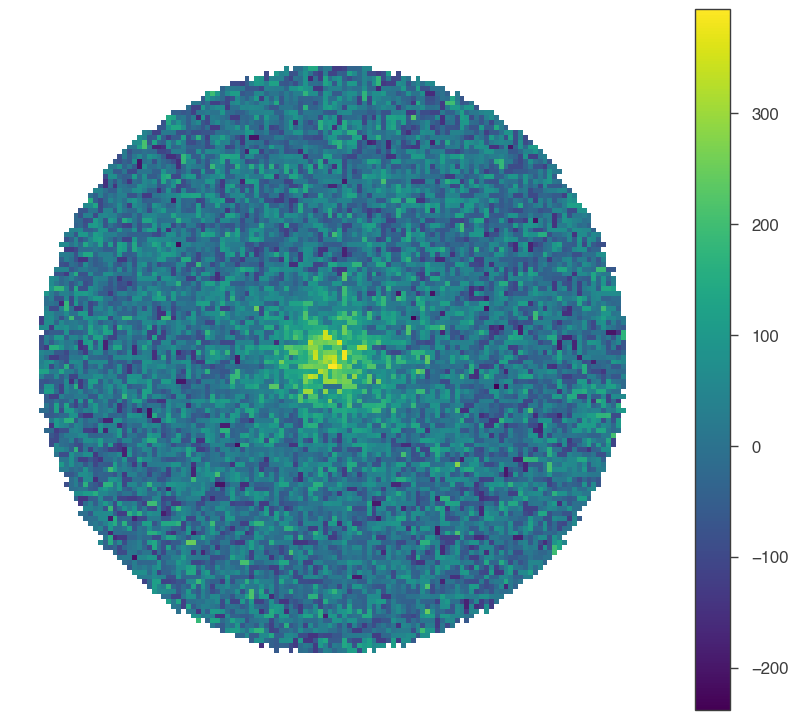

In [5]:
fig = hawc.display_stacked_image(smoothing_kernel_sigma=0.01)

What about smoothing it with a smoothing kernel comparable to the PSF? (Note the change in the color scale!)

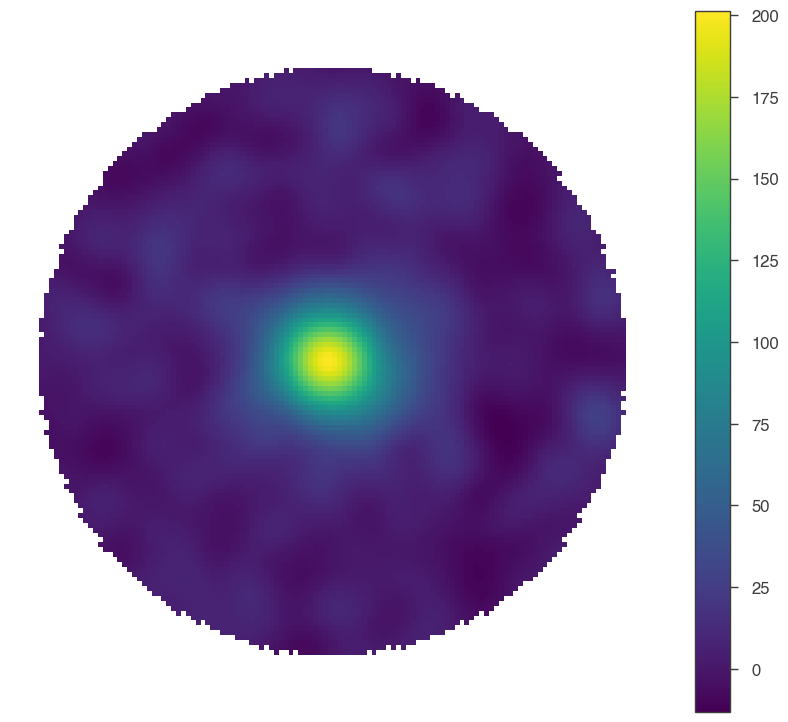

In [6]:
fig_smooth = hawc.display_stacked_image(smoothing_kernel_sigma=0.2)

Now, let's see how the data change from bin to bin (feel free to play around with the smoothing radius here)!

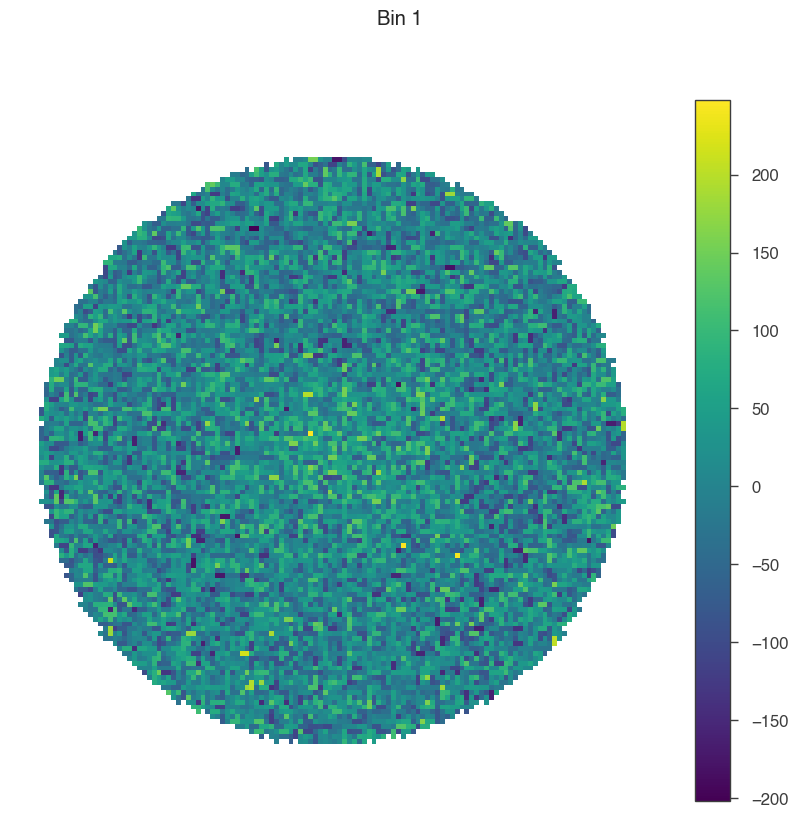

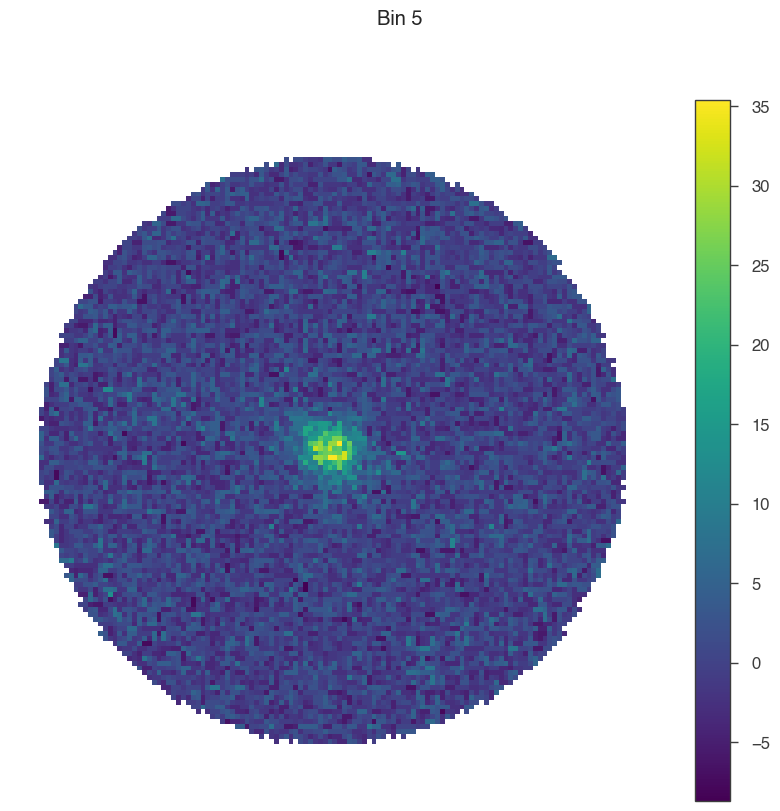

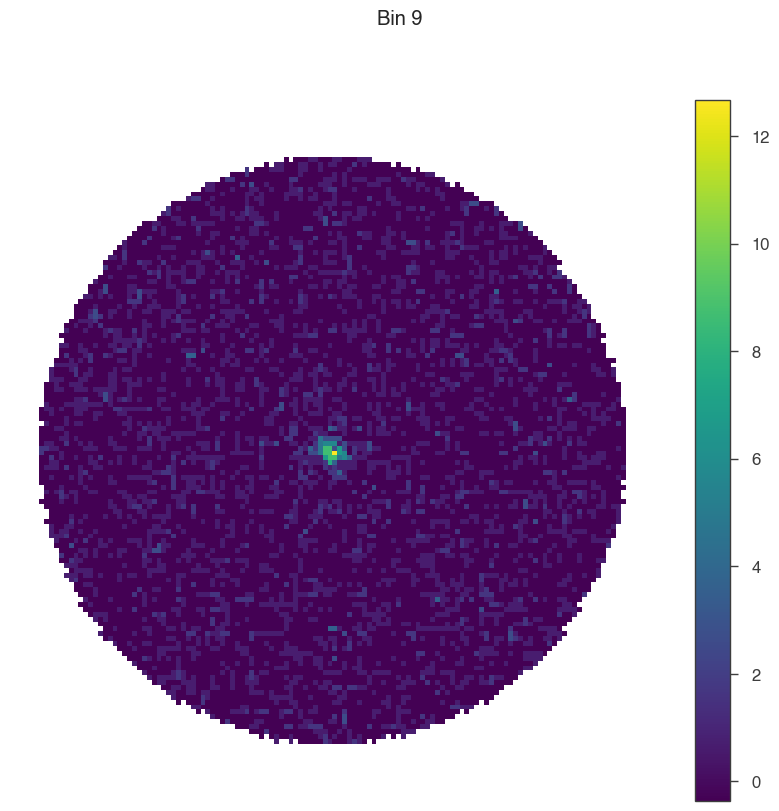

In [7]:
for bin in [1, 5, 9]:
    # set only one active bin
    hawc.set_active_measurements(bin, bin)

    fig = hawc.display_stacked_image(smoothing_kernel_sigma=0.01)
    fig.suptitle(f"Bin {bin}")

<!-- fig.suptitle("Bin {}".format(bin)) -->

Smaller bins have more events overall, but also more background, and a larger PSF.

## Simple model fit

Let's set up a simple one-source model with a log-parabolic spectrum. For now, the source position will be fixed to its nominal position.

In [8]:
# Define model
spectrum = Log_parabola()
source = PointSource("crab", ra=ra_crab, dec=dec_crab, spectral_shape=spectrum)

spectrum.piv = 7 * u.TeV
spectrum.piv.fix = True

spectrum.K = 1e-14 / (u.TeV * u.cm**2 * u.s)  # norm (in 1/(TeV cm2 s))
spectrum.K.bounds = (1e-35, 1e-10) / (
    u.TeV * u.cm**2 * u.s
)  # without units energies would be in keV

spectrum.alpha = -2.5  # log parabolic alpha (index)
spectrum.alpha.bounds = (-4.0, 2.0)

spectrum.beta = 0  # log parabolic beta (curvature)
spectrum.beta.bounds = (-1.0, 1.0)

model = Model(source)

model.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (3):
--------------------

                                      value min_value max_value  \
crab.spectrum.main.Log_parabola.K       0.0       0.0       0.0   
crab.spectrum.main.Log_parabola.alpha  -2.5      -4.0       2.0   
crab.spectrum.main.Log_parabola.beta    0.0      -1.0       1.0   

                                                 unit  
crab.spectrum.main.Log_parabola.K      keV-1 s-1 cm-2  
crab.spectrum.main.Log_parabola.alpha                  
crab.spectrum.main.Log_parabola.beta                   

Fixed parameters (3):
---------------------

                                            value min_value max_value unit
crab.position.ra                            83.63       0.0     360.0  deg
crab.position.dec                           22.02     -90.0      90.0  deg
crab.spectrum.main.Log_parabola.piv  7000000000.0      None      None  keV

Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

Next, set up the likelihood object and run the fit. Fit results are written to disk so they can be read in again later.

In [9]:
# make sure to re-set the active bins before the fit
hawc.set_active_measurements(1, 9)
data = DataList(hawc)

jl = JointLikelihood(model, data, verbose=False)
jl.set_minimizer("minuit")
param_df, like_df = jl.fit()

results = jl.results
results.write_to("crab_lp_public_results.fits", overwrite=True)
results.optimized_model.save("crab_fit.yml", overwrite=True)

18:37:29 INFO      set the minimizer to minuit                                             ]8;id=47754;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=758037;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=869570;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=450845;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(2.54 +/- 0.06) x 10^-22,1 / (cm2 keV s)
crab.spectrum.main.Log_parabola.alpha,-2.646 +/- 0.018,
crab.spectrum.main.Log_parabola.beta,(1.04 +/- 0.14) x 10^-1,


Correlation matrix:

1.00,-0.07,0.83
-0.07,1.00,-0.39
0.83,-0.39,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
HAWC,18765.836789
total,18765.836789


Values of statistical measures:

,statistical measures
AIC,37537.673855
BIC,37565.769984


## Assessing the Fit Quality

`HAL` and `threeML` provide several ways to assess the quality of the provided model, both quantitatively and qualitatively.

For a first visual impression, we can display the model, excess (counts - background), background, and residuals (counts - model - background) for each bin.

Smoothing planes:   0%|          | 0/9 [00:00<?, ?it/s]

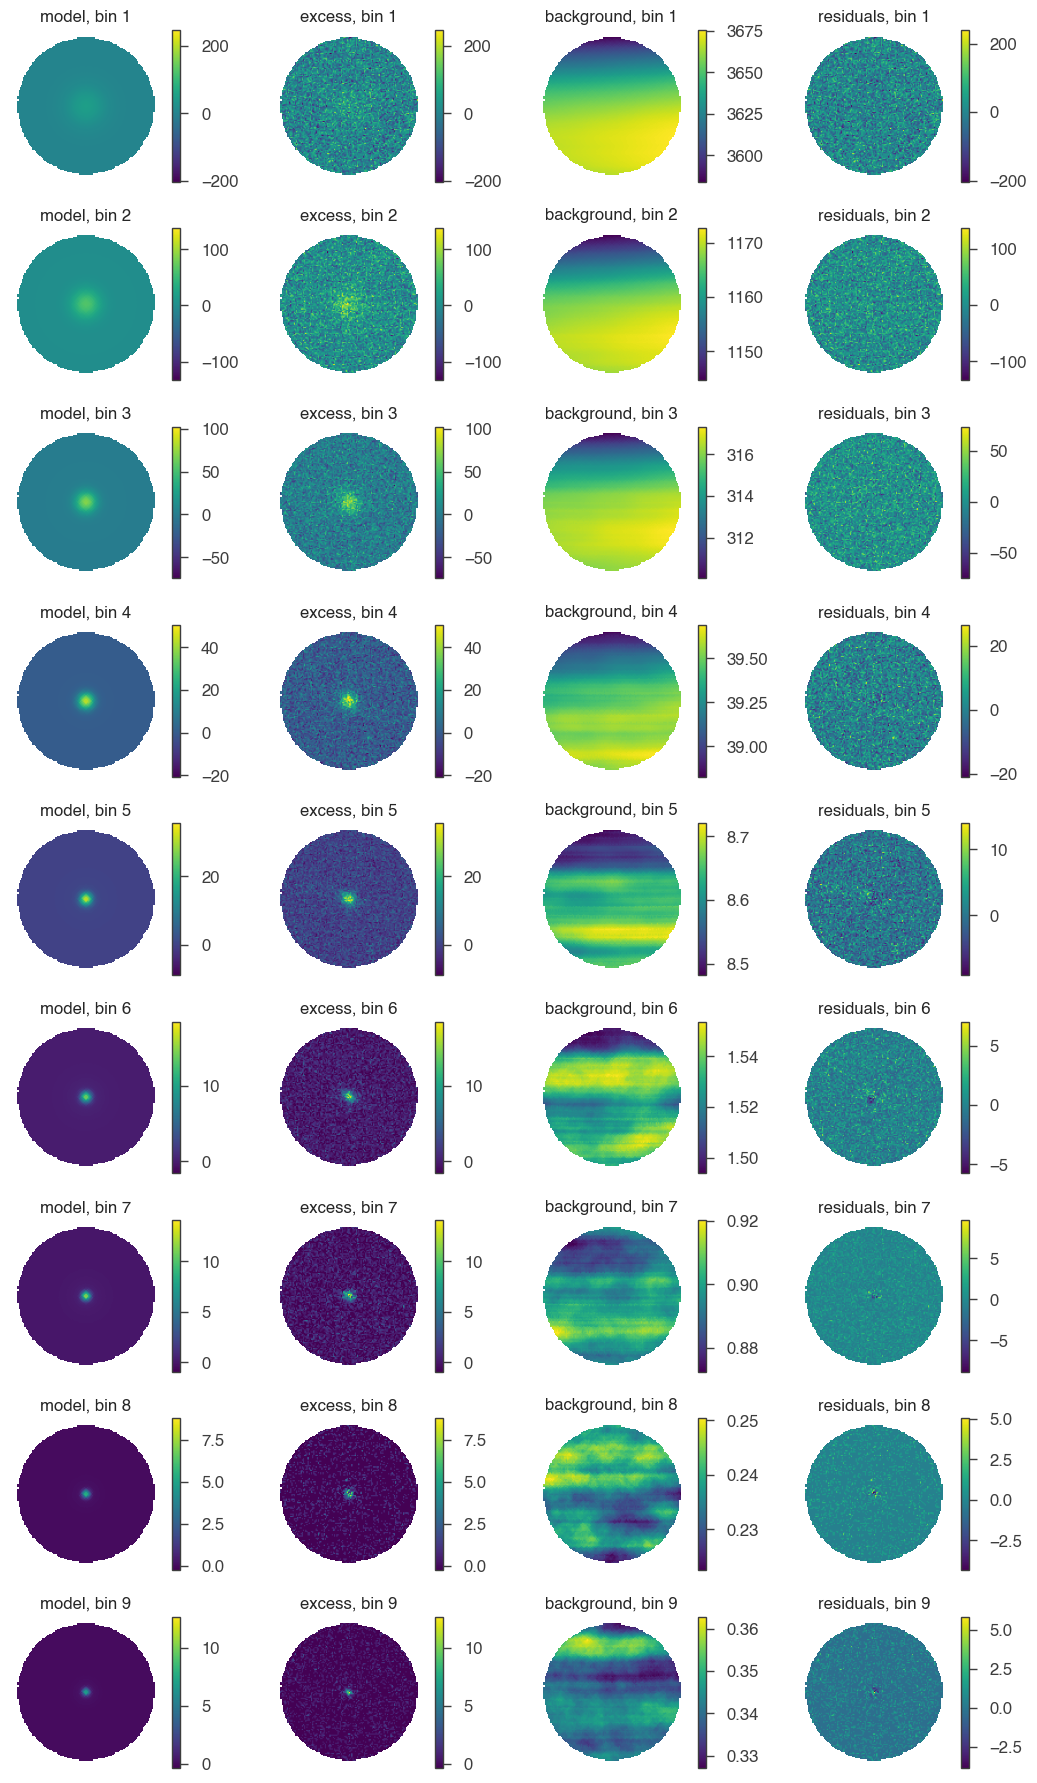

In [10]:
fig = hawc.display_fit(smoothing_kernel_sigma=0.01, display_colorbar=True)

Same, but with smoothing:

Smoothing planes:   0%|          | 0/9 [00:00<?, ?it/s]

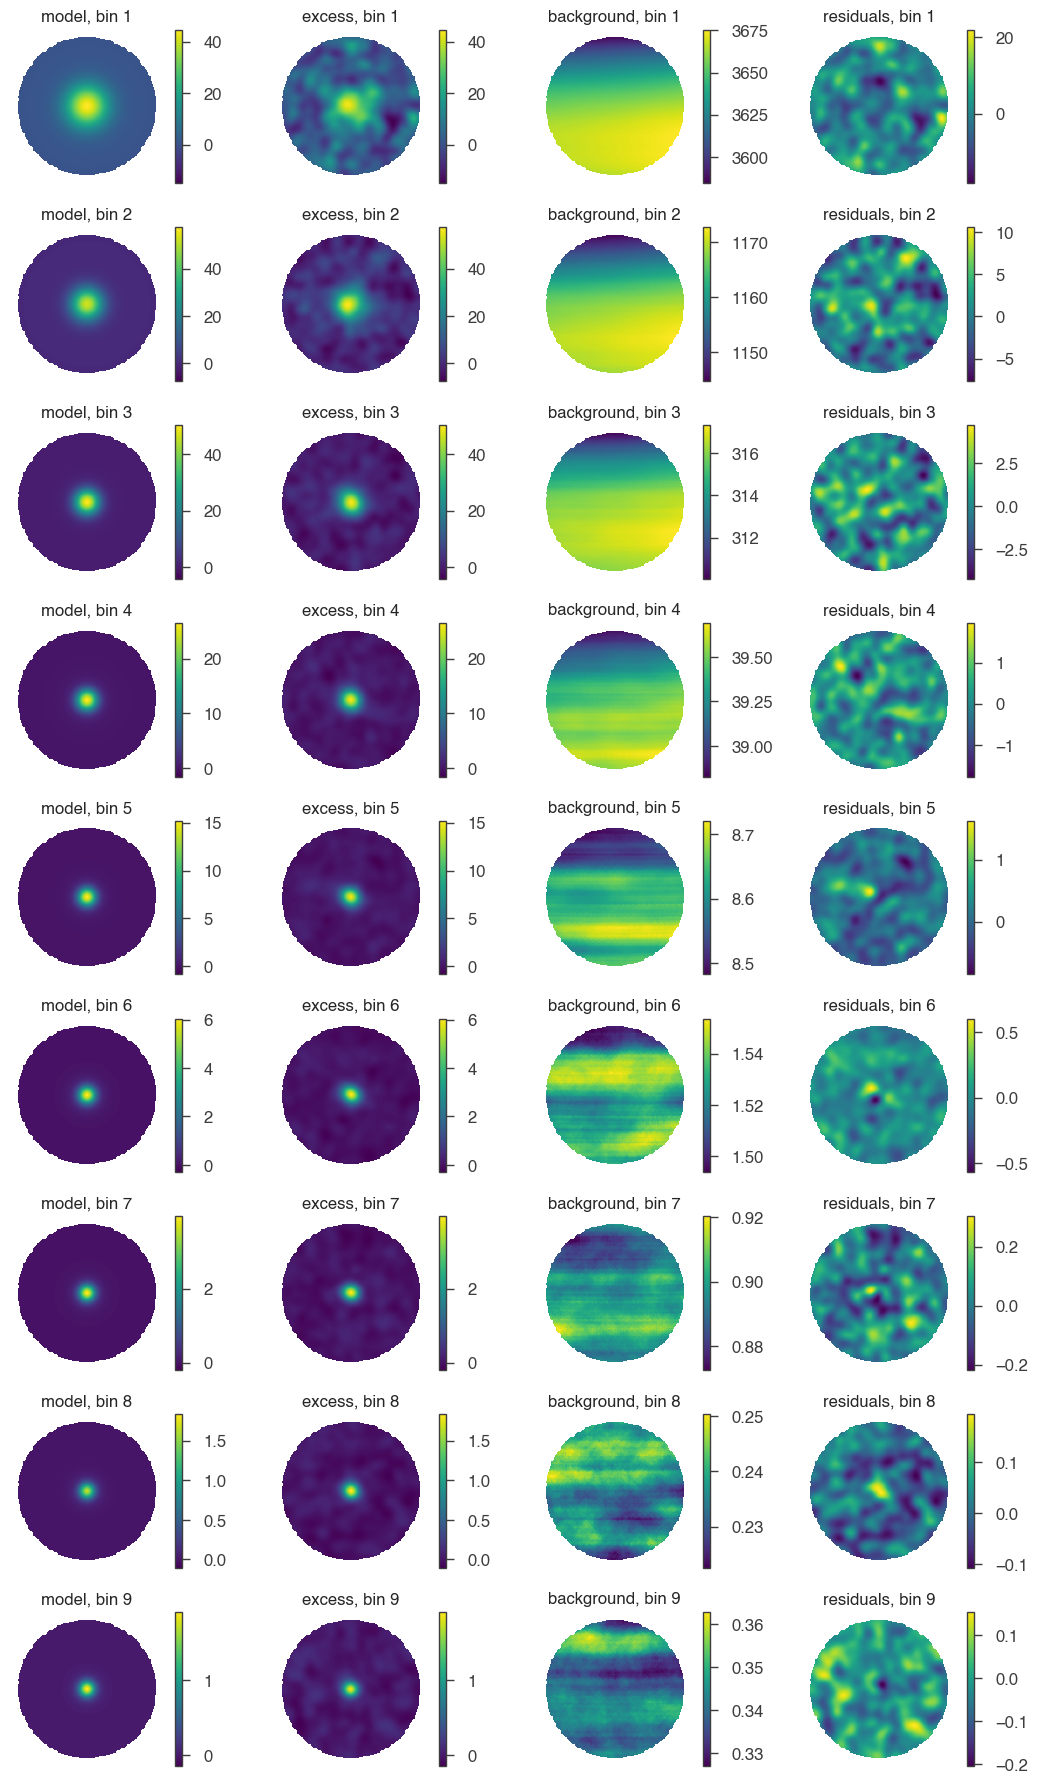

In [11]:
fig = hawc.display_fit(smoothing_kernel_sigma=0.2, display_colorbar=True)

The following plot provides a summary of the images above:

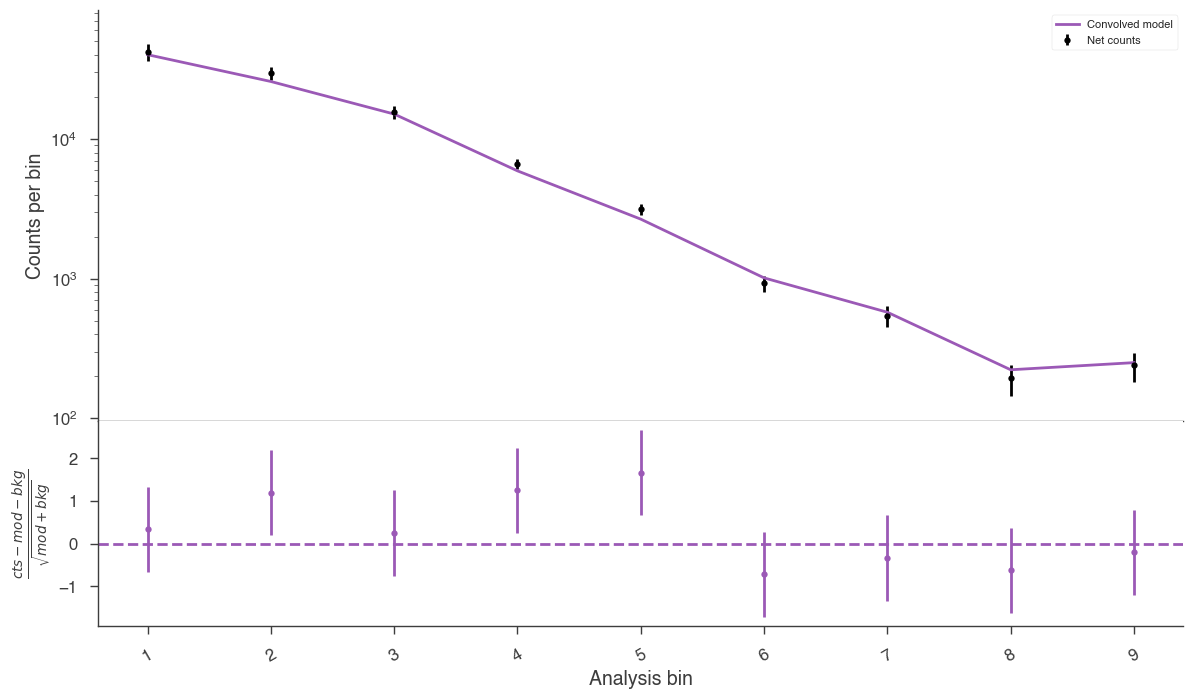

In [12]:
fig = hawc.display_spectrum()

The `GoodnessOfFit` module provides a numerical assessment of the goodness of fit, by comparing the best-fit likelihood from the fit to likelihood values seen in "simulated" data (background + source model + pseudo-random poissonian fluctuation).

In [13]:
gof_obj = GoodnessOfFit(jl)
gof, data_frame, like_data_frame = gof_obj.by_mc(n_iterations=200)

Goodness of fit computation:   0%|          | 0/200 [00:00<?, ?it/s]

Goodness of fit (p-value:) 0.095
Meaning that 9.5% of simulations have a larger (worse) likelihood
and 90.5% of simulations have a smaller (better) likelihood than seen in data


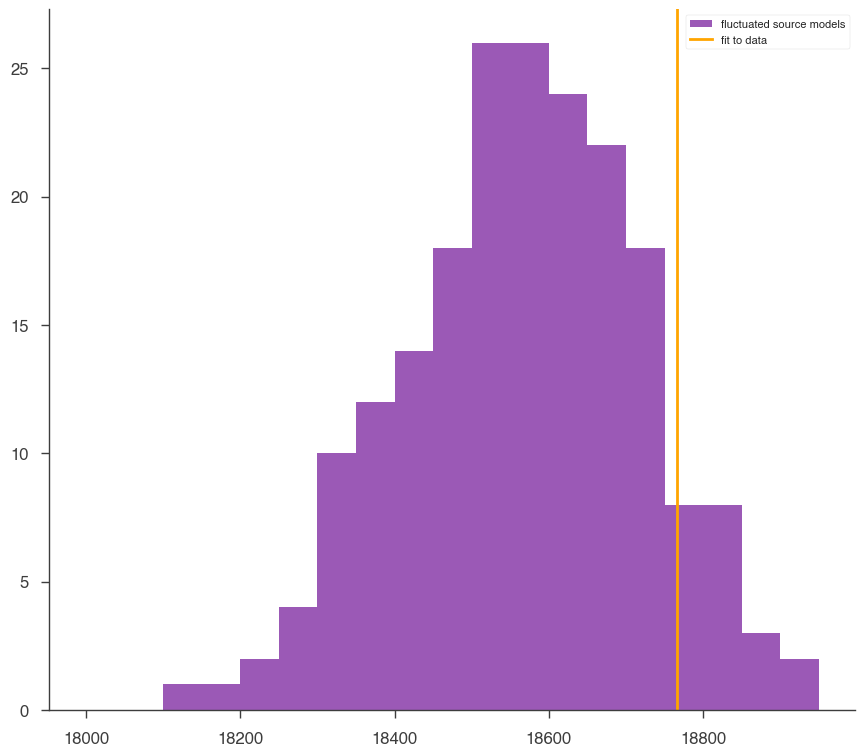

In [14]:
p = gof["total"]

print("Goodness of fit (p-value:)", p)
print(f"Meaning that {100*p:.1f}% of simulations have a larger (worse) likelihood")
print(
    f"and {100*(1-p):.1f}% of simulations have a smaller (better) likelihood than seen in data"
)

df = like_data_frame.reset_index()
df = df[df.level_1 == "total"]

fig, ax = plt.subplots()
ax.hist(
    df["-log(likelihood)"],
    label="fluctuated source models",
    bins=range(18000, 19000, 50),
)
ax.axvline(
    like_df.loc["total", "-log(likelihood)"], label="fit to data", color="orange"
)
ax.xlabel = "-log(likelihood)"
ax.legend(loc="best")

<!-- print("and {:.1f}% of simulations have a smaller (better) likelihood than seen in data".format(100*(1-p) ) ) -->
<!-- print("Meaning that {:.1f}% of simulations have a larger (worse) likelihood".format(100*p) ) -->

Not too bad, but not great 🙃. The model might be improved by freeing the position or choosing another spectral shape. However, note that the detector response file provided here is the one used in the 2017 publication, which has since been superceeded by an updated detector model (only available inside the HAWC collaboration for now). Discrepancies between the simulated and true detector response may also worsen the goodness of fit.

## Visualizing the Fit Results

Now that we have satisfied ourselves that the best-fit model describes the data reasonably well, let's look at the fit parameters. First, let's print them again:

In [15]:
param_df

,value,negative_error,positive_error,error,unit
crab.spectrum.main.Log_parabola.K,2.540435e-22,-6.498431e-24,6.140098e-24,6.319265e-24,1 / (cm2 keV s)
crab.spectrum.main.Log_parabola.alpha,-2.645943e+00,-1.838012e-02,1.813086e-02,1.825549e-02,
crab.spectrum.main.Log_parabola.beta,1.038791e-01,-1.471336e-02,1.426753e-02,1.449045e-02,


Plot the spectrum using `threeML`'s `plot_spectra` convenience function:

processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 0, 'Energy [TeV]')

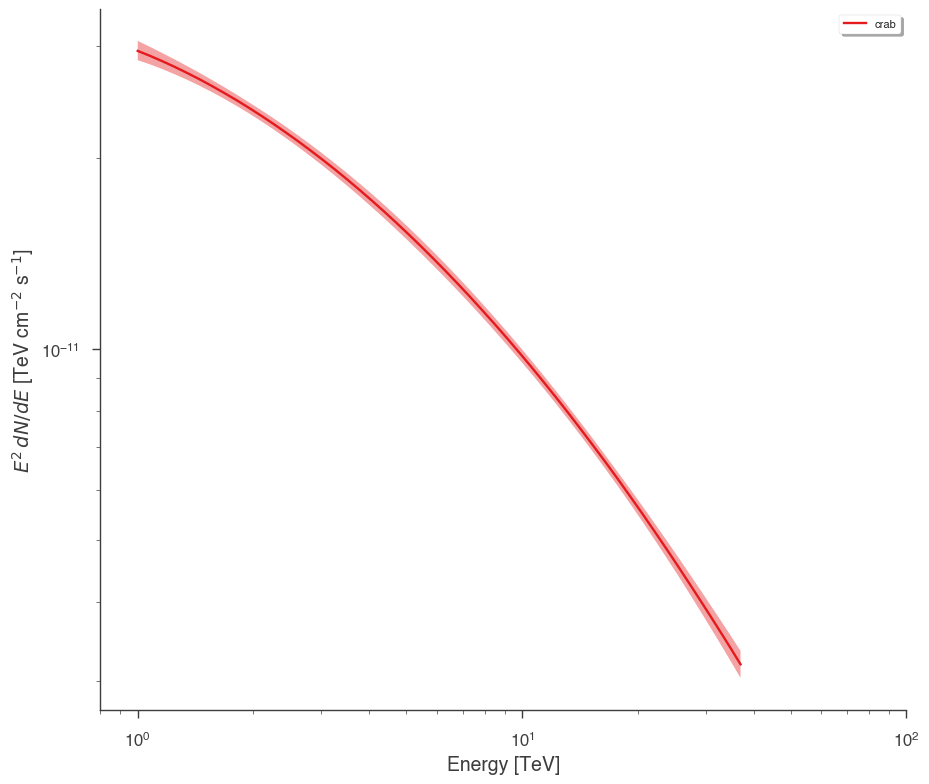

In [16]:
fig, ax = plt.subplots()

plot_spectra(
    results,
    ene_min=1.0,
    ene_max=37,
    num_ene=50,
    energy_unit="TeV",
    flux_unit="TeV/(s cm2)",
    subplot=ax,
)
ax.set_xlim(0.8, 100)
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")

What about visualizing the fit parameter's uncertainties and their correlations? We can use _likelihood profiles_ for that. We need to provide the range for the contours. We can derive a reasonable range from the best-fit values and their uncertainties.

Profiling likelihood:   0%|          | 0/400 [00:00<?, ?it/s]

Profiling likelihood:   0%|          | 0/400 [00:00<?, ?it/s]

Profiling likelihood:   0%|          | 0/400 [00:00<?, ?it/s]

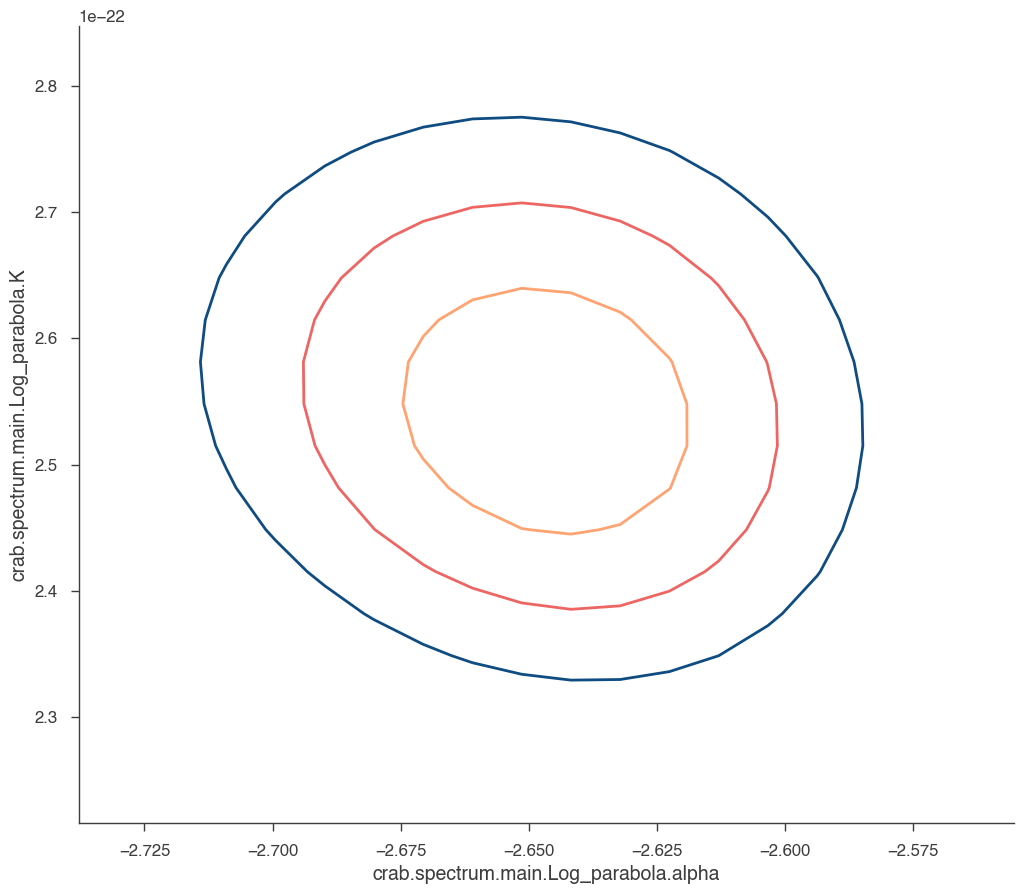

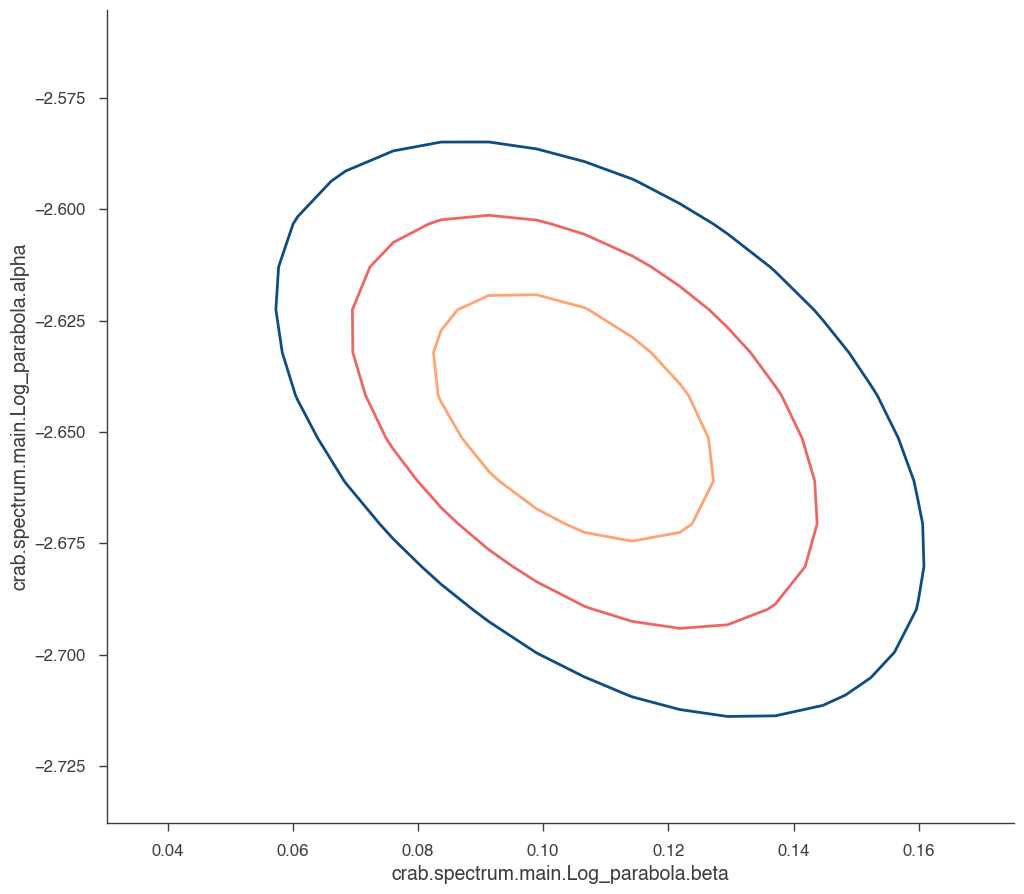

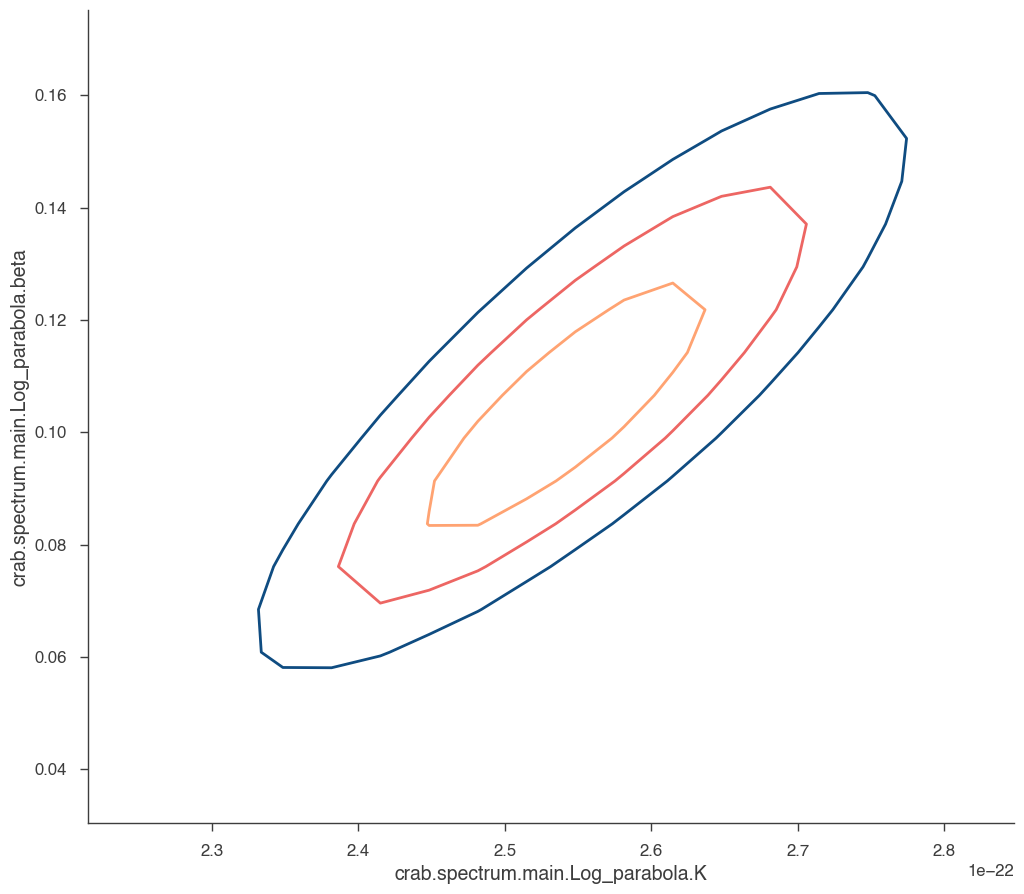

In [17]:
range_min = {}
range_max = {}

params = model.free_parameters
N_param = len(model.free_parameters.keys())

for name in params:
    row = param_df.loc[name]
    range_min[name] = row["value"] + 5 * row["negative_error"]
    range_max[name] = row["value"] + 5 * row["positive_error"]

for i in range(0, N_param):
    p1 = list(params.keys())[i]
    p2 = list(params.keys())[(i + 1) % N_param]

    a, b, cc, fig = jl.get_contours(
        p1, range_min[p1], range_max[p1], 20, p2, range_min[p2], range_max[p2], 20
    )

We can see that the index and normalization are essentially uncorrelated (as the pivot energy was chosen accordingly). There is significant correlation between the spectral index and the curvature parameter though.